# Heston Model Simulation Demo

This notebook demonstrates how to use the custom `Heston` class to simulate asset price paths using the Heston stochastic volatility model.

We illustrate both:
- The one-dimensional case (single asset)
- The multidimensional case (multiple assets with correlated volatility)


In [1]:
import sys
from pathlib import Path

# Add the path to import the custom Heston model
sys.path.append(str(Path().resolve().parents[0] / "src"))

from models.Heston import Heston
import numpy as np
import matplotlib.pyplot as plt


## One-dimensional Heston model

We consider a single asset whose price follows the Heston stochastic volatility model:

$$
\begin{aligned}
dS_t &= S_t \left( r \, dt + \sqrt{v_t} \, dW_t^{(1)} \right), \\\\
dv_t &= \kappa (\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^{(2)},
\end{aligned}
$$

where:
- $r$ is the risk-free rate,
- $v_t$ is the instantaneous variance,
- $\kappa$, $\theta$, and $\sigma$ are mean-reversion parameters,
- $W^{(1)}$ and $W^{(2)}$ are Brownian motions with correlation $\rho$:
  $$
  \mathbb{E}[dW_t^{(1)} dW_t^{(2)}] = \rho \, dt.
  $$

We simulate the model using an Euler-Maruyama scheme and generate 10 sample paths over a one-year horizon.


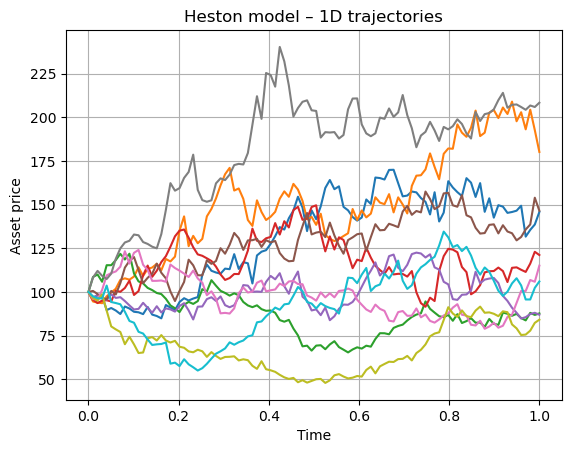

In [2]:
# Create the Heston model
heston = Heston(v0=0.2, r=0.03, kappa=0.02, theta=0.4, sigma=0.1, rho=0.4, g = np.abs)

# Generate 10 trajectories
S = heston.generate_trajectories(S0=100, T=1, N=100, n_paths=10)

# Plot the paths
for i in range(10):
    plt.plot(np.linspace(0,1,100), S[:, i])
plt.title("Heston model – 1D trajectories")
plt.xlabel("Time")
plt.ylabel("Asset price")
plt.grid(True)
plt.show()


## Multidimensional Heston model

We consider a $d$-dimensional Heston model. Each asset has its own stochastic variance process. Let $S_t \in \mathbb{R}^d$ be the vector of asset prices and $v_t \in \mathbb{R}^d$ the vector of variances.

The dynamics are:

$$
\begin{aligned}
dS_t &= \operatorname{diag}(S_t) \left( r \, \mathbf{1} \, dt + \sqrt{v_t} \odot dW_t^{(1)} \right), \\\\
dv_t &= \kappa \odot (\theta - v_t) \, dt + \sigma \odot \sqrt{v_t} \odot dW_t^{(2)},
\end{aligned}
$$

where:
- $r \in \mathbb{R}$ is the risk-free rate,
- $\kappa, \theta, \sigma \in \mathbb{R}^d$ are the Heston parameters (element-wise),
- $W_t^{(1)}, W_t^{(2)} \in \mathbb{R}^d$ are $d$-dimensional Brownian motions,
- $\odot$ denotes the element-wise (Hadamard) product.

The $2d$-dimensional Brownian motion $\left( W_t^{(1)}, W_t^{(2)} \right)$ has a correlation matrix $\Sigma \in \mathbb{R}^{2d \times 2d}$, which can be written in block form:

$$
\Sigma =
\begin{bmatrix}
\Sigma_{SS} & \Sigma_{Sv} \\\\
\Sigma_{vS} & \Sigma_{vv}
\end{bmatrix}
$$

where each block is in $\mathbb{R}^{d \times d}$:
- $\Sigma_{SS}$: correlation between asset prices,
- $\Sigma_{vv}$: correlation between variances,
- $\Sigma_{Sv}$ and $\Sigma_{vS}$: cross-correlations between prices and variances.

We simulate the process using an Euler scheme on the full $2d$-dimensional system.


In [3]:
heston2 = Heston(
    v0=np.array([0.2, 0.1]),
    r=0.03,
    kappa=np.array([0.02, 0.1]),
    theta=np.array([0.4, 0.3]),
    sigma=np.array([0.1, 0.2]),
    rho=np.array([
        [1.00, 0.30, 0.20, 0.10],
        [0.30, 1.00, 0.40, 0.25],
        [0.20, 0.40, 1.00, 0.35],
        [0.10, 0.25, 0.35, 1.00]
    ]),
    g = np.abs
)

# Simulate 2D asset prices
S2 = heston2.generate_trajectories(S0=np.array([100, 80]), T=1, N=100, n_paths=10)


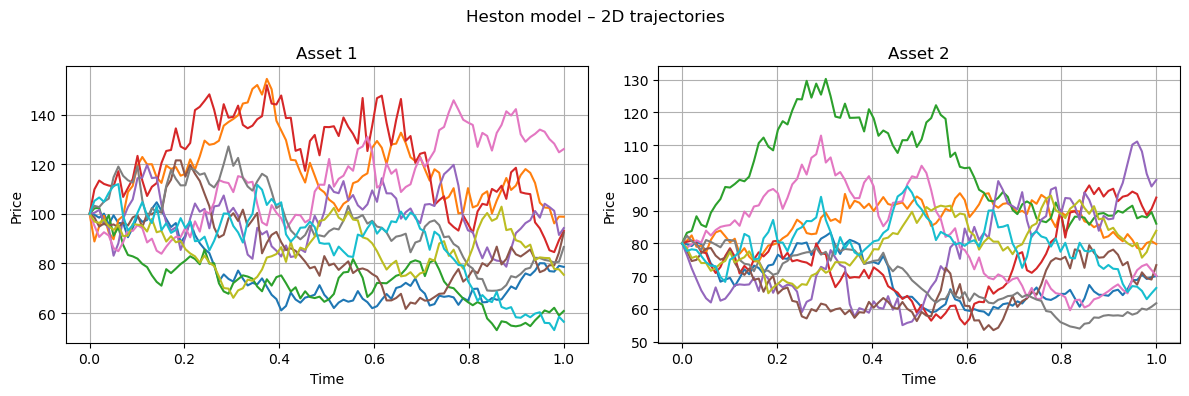

In [4]:
# Plot asset 1 and asset 2 trajectories
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i in range(10):
    axs[0].plot(np.linspace(0,1,100), S2[:, i, 0])
    axs[1].plot(np.linspace(0,1,100), S2[:, i, 1])

axs[0].set_title("Asset 1")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Price")

axs[1].set_title("Asset 2")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Price")

for ax in axs:
    ax.grid(True)

plt.suptitle("Heston model – 2D trajectories")
plt.tight_layout()
plt.show()
